In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [2]:
!pip -q install xgboost lightgbm

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import accuracy_score
# from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [8]:
data_dir = '~/work/AIFFEL_quest_eng/Main_Quest/Quest01/spaceship-titanic'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [ ]:
# # # 데이터 로드
# train = pd.read_csv("/content/train.csv")
# test  = pd.read_csv("/content/test.csv")


In [9]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


None

In [10]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [ ]:
# train['HomePlanet'] = train['HomePlanet'].fillna(train['HomePlanet'].mode()[0])


[Target counts]


Transported
True     4378
False    4315
Name: count, dtype: int64


[Target ratio]


Transported
True     0.5036
False    0.4964
Name: proportion, dtype: float64

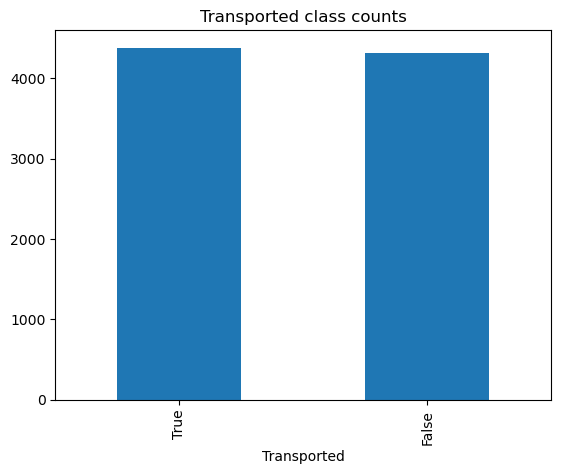

In [11]:
target_counts = train["Transported"].value_counts()
target_ratio = train["Transported"].value_counts(normalize=True).round(4)
print("\n[Target counts]")

display(target_counts)
print("\n[Target ratio]")
display(target_ratio)

plt.figure()
target_counts.plot(kind="bar")
plt.title("Transported class counts")
plt.show()

In [13]:
!pip -q install missingno

<Axes: >

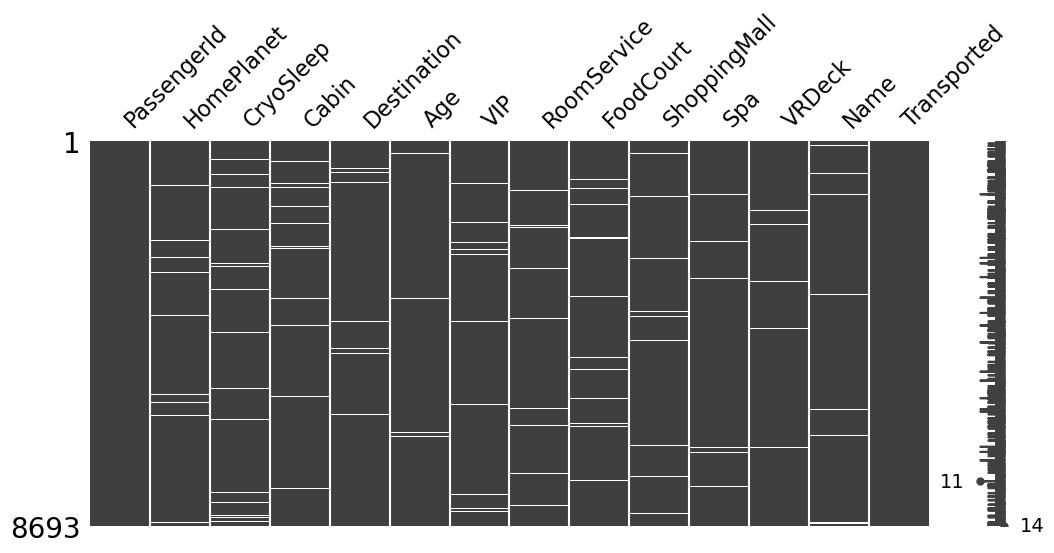

In [14]:
import missingno as msno
msno.matrix(train, figsize=(12, 5))

In [15]:
#Transported에 대한 비율
def rate_by_cat(col):
    return (pd.crosstab(train[col], train["Transported"], normalize="index") * 100).round(1)

In [16]:
rate_by_cat("Destination")

Transported,False,True
Destination,,
55 Cancri e,39.0,61.0
PSO J318.5-22,49.6,50.4
TRAPPIST-1e,52.9,47.1


In [17]:
rate_by_cat("CryoSleep")

Transported,False,True
CryoSleep,,
False,67.1,32.9
True,18.2,81.8


## 함수 만들기


In [18]:

# 1. Feature Engineering: Cabin split
def split_cabin(df):
    df['Cabin'] = df['Cabin'].fillna('Unknown/Unknown/Unknown')
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    return df

In [19]:
train = split_cabin(train)
test = split_cabin(test)

In [20]:
test_passenger_ids = test['PassengerId'].copy()

In [21]:
# 2. Handle missing values


numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

# Numerical Imputation (Median)
for col in numerical_cols:
    fill_value = train[col].median()
    train[col] = train[col].fillna(fill_value)
    test[col] = test[col].fillna(fill_value)

# Categorical Imputation (Mode)
for col in categorical_cols:
    fill_value = train[col].mode()[0]
    train[col] = train[col].fillna(fill_value)
    test[col] = test[col].fillna(fill_value)

/tmp/ipykernel_201/1904657779.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train[col] = train[col].fillna(fill_value)
/tmp/ipykernel_201/1904657779.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test[col] = test[col].fillna(fill_value)


In [22]:
# 3. Encoding Categorical Variables

le = LabelEncoder()
cols_to_encode = categorical_cols + ['Num']
for col in cols_to_encode:
    # Full data concatenation to align labels between train and test
    full_data = pd.concat([train[col].astype(str), test[col].astype(str)], axis=0)
    le.fit(full_data)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))
print("Preprocessing and Encoding Done!")

Preprocessing and Encoding Done!


## 모델링


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [24]:
drop_cols = ['PassengerId', 'Cabin', 'Name']
X = train.drop(['Transported'] + drop_cols, axis=1)
y = train['Transported'].astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2020)


In [25]:
models = {
    "GBM": GradientBoostingClassifier(random_state=2020),
    "XGB": XGBClassifier(random_state=2020, use_label_encoder=False, eval_metric='logloss'),
    "LGBM": LGBMClassifier(random_state=2020),
    "RF": RandomForestClassifier(random_state=2020)
}


In [26]:
scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    scores[name] = accuracy_score(y_val, y_pred)
score_df = pd.DataFrame(scores, index=['Accuracy']).T.sort_values(by='Accuracy', ascending=False)
score_df

/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:04:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 3494, number of negative: 3460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1630
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502445 -> initscore=0.009779
[LightGBM] [Info] Start training from score 0.009779


,Accuracy
XGB,0.814836
LGBM,0.811961
GBM,0.803335
RF,0.802760


In [27]:
print("Model Training & Evaluation:")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    print(f"{name} Accuracy: {accuracy_score(y_val, y_pred):.4f}")

Model Training & Evaluation:
GBM Accuracy: 0.8033
XGB Accuracy: 0.8148


/opt/conda/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [13:04:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 3494, number of negative: 3460
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1630
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502445 -> initscore=0.009779
[LightGBM] [Info] Start training from score 0.009779
LGBM Accuracy: 0.8120
RF Accuracy: 0.8028


In [30]:

best_model = models["LGBM"] # score_df에서 가장 높은 모델을 선택하세요


In [31]:
# 2. Prepare test data features (same drops as training)
X_test_final = test.drop(drop_cols, axis=1)

# 3. Predict
final_predictions = best_model.predict(X_test_final)

# 4. Create Submission DataFrame

submission = pd.DataFrame({
    "PassengerId": test_passenger_ids, # Preprocessing 단계에서 보관하거나 test['PassengerId'] 사용
    "Transported": final_predictions.astype(bool)
})


In [32]:
submission.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' has been created!")

Submission file 'submission.csv' has been created!


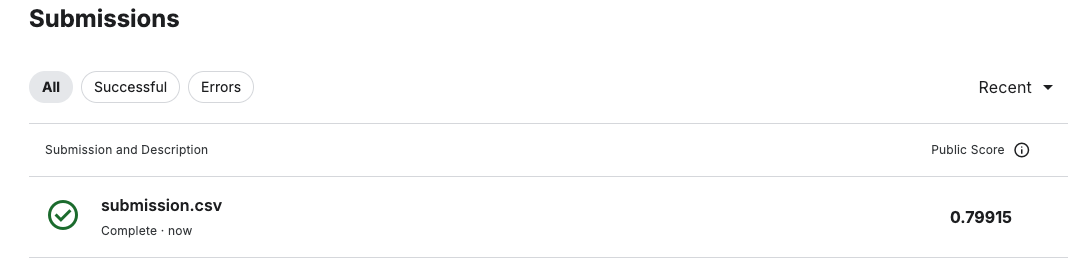